BERT MODEL

In [2]:
import json
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset


def load_and_prepare_data(json_file):
    with open(json_file) as f:
        data = json.load(f)

    patterns = []
    tags = []

    for intent in data['intents']:
        for pattern in intent['patterns']:
            patterns.append(pattern)
            tags.append(intent['tag'])

    return patterns, tags

class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Modified line
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

patterns, tags = load_and_prepare_data('intents.json')
label_encoder = LabelEncoder()
encoded_tags = label_encoder.fit_transform(tags)


train_texts, val_texts, train_encoded_tags, val_encoded_tags = train_test_split(patterns, encoded_tags, test_size=0.1, random_state=15)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt")
train_dataset = IntentDataset(train_encodings, train_encoded_tags)
val_dataset = IntentDataset(val_encodings, val_encoded_tags)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
model.save_pretrained('./intent_classification_model')
tokenizer.save_pretrained('./intent_classification_model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,4.500100
20,4.499500
30,4.462800


('./intent_classification_model/tokenizer_config.json',
 './intent_classification_model/special_tokens_map.json',
 './intent_classification_model/vocab.txt',
 './intent_classification_model/added_tokens.json')

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model_path = './intent_classification_model'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [2]:
intent_responses = {
    "greeting": ["Hello!", "Hi there, how can I help you today?"],
}

In [3]:
def chat_with_bot():
    print("Chat with the bot (type 'quit' to stop)!")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break
        inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        
        predicted_intent_idx = torch.argmax(outputs.logits, dim=1).item()
        predicted_intent = model.config.id2label[predicted_intent_idx]
        response = intent_responses.get(predicted_intent, ["Sorry, I don't understand."])[0]
        print(f"Bot: {response}")

In [ ]:
chat_with_bot()

Chat with the bot (type 'quit' to stop)!


You:  Hello!


Bot: Sorry, I don't understand.


You:  greeting


Bot: Sorry, I don't understand.


You:  Hey


Bot: Sorry, I don't understand.


You:  Hi


Bot: Sorry, I don't understand.


SIMPLE BASED QUESTION/ANSWERING MODEL with SRL

In [7]:
import json
import random
import spacy

nlp = spacy.load("en_core_web_sm")

def load_intents(filename):
    with open(filename, 'r') as file:
        intents = json.load(file)
    return intents
  
def preprocess_intents(intents):
    qa_pairs = {}
    for intent in intents['intents']:
        tag = intent['tag']
        patterns = intent['patterns']
        responses = intent['responses']
        for pattern in patterns:
            qa_pairs[pattern.lower()] = {'tag': tag, 'responses': responses}
    return qa_pairs

def extract_semantic_roles(question):
    roles = {}
    doc = nlp(question)
    for token in doc:
        roles[token.text] = token.dep_
    return roles

def answer_question(question, qa_pairs):
    question = question.lower()
    words = question.split()
    matched_tag_responses = []
    roles = extract_semantic_roles(question)
    for word in words:
        for pattern, intent_info in qa_pairs.items():
            if word in intent_info['tag']:
                matched_tag_responses.extend(intent_info['responses'])

    decomposed_inputs = []
    for word, role in roles.items():
        decomposed_input = f"{word}_{role}"
        decomposed_inputs.append(decomposed_input)
        print(f"Word: {word}, Role: {role}")
    if matched_tag_responses:
        return random.choice(matched_tag_responses)
    
    if question in qa_pairs:
        intent_info = qa_pairs[question]
        responses = intent_info['responses']
        return random.choice(responses)
    else:
        return "Sorry, I don't understand your question."
intents = load_intents('intents.json')
qa_pairs = preprocess_intents(intents)

question = "I'm stressed"

answer = answer_question(question, qa_pairs)
print(answer)

Word: i, Role: nsubj
Word: 'm, Role: auxpass
Word: stressed, Role: ROOT
Give yourself a break. Go easy on yourself.


GPT-2 MODEL

In [10]:
import json
import torch
import numpy as np
import transformers
from transformers import BertTokenizer, BertForTokenClassification
from torch.utils.data import DataLoader
from transformers import pipeline
import spacy
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [9]:
with open('intents.json') as file:
    data = json.load(file)
patterns = []
responses = []
tags = []
for intent in data['intents']:
    patterns.extend(intent['patterns'])
    responses.extend(intent['responses'])
    tags.append(intent['tag'])

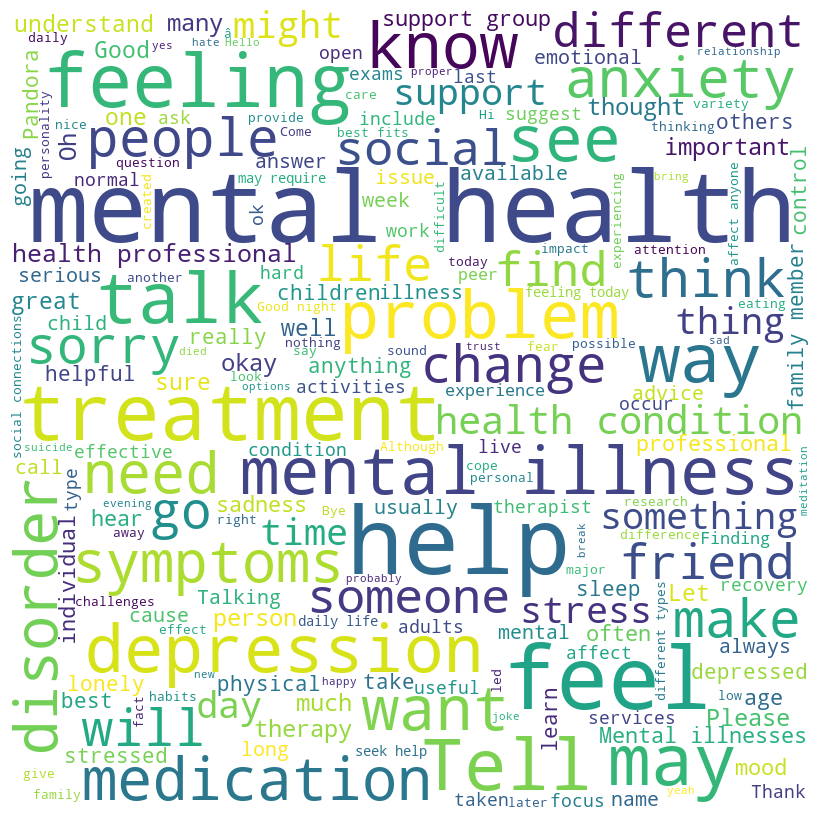

388


In [11]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
text = patterns + responses

def generate_word_cloud(text_list):
    text = ' '.join(text_list)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

generate_word_cloud(text)

tokenized_text = tokenizer.encode(text, add_special_tokens=True)
print(len(tokenized_text))
with open("tokenized_text10.txt", "w") as file:
    for token in tokenized_text:
        file.write(str(token) + "\n")

Epoch 1: Average Loss: 1.1412687141174622
Epoch 2: Average Loss: 1.027594411354416
Epoch 3: Average Loss: 0.818289917173613
Epoch 4: Average Loss: 0.7739699881106192
Epoch 5: Average Loss: 0.6841014058391574
Epoch 6: Average Loss: 0.7555381384217325
Epoch 7: Average Loss: 0.6319903336350143
Epoch 8: Average Loss: 0.5849157912301418
Epoch 9: Average Loss: 0.5493977629128344
Epoch 10: Average Loss: 0.5454195649555126


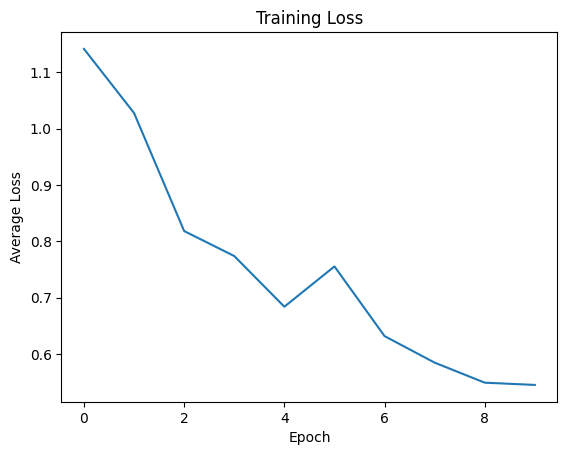

('fine_tuned_gpt2_modelfinal\\tokenizer_config.json',
 'fine_tuned_gpt2_modelfinal\\special_tokens_map.json',
 'fine_tuned_gpt2_modelfinal\\vocab.json',
 'fine_tuned_gpt2_modelfinal\\merges.txt',
 'fine_tuned_gpt2_modelfinal\\added_tokens.json')

In [13]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_text):
        self.tokenized_text = tokenized_text

    def __len__(self):
        return len(self.tokenized_text)

    def __getitem__(self, idx):
        return torch.tensor(self.tokenized_text[idx])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

dataset = CustomDataset(tokenized_text)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
model.train()
losses = []
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Average Loss: {avg_loss}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.show()

model_path = "fine_tuned_gpt2_modelfinal"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

PREDICTIONS FOR OUR FINE-TUNED MODEL CHATBOT

In [15]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#PREDICTIONS FROM OUR FINE-TUNED MODEL
model = GPT2LMHeadModel.from_pretrained("fine_tuned_gpt2_modelfinal")
def chat():
    print("Start chatting! Type 'exit' to end the conversation.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        input_ids = tokenizer.encode(user_input, return_tensors='pt').to(device)
        output = model.generate(input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(output[0], skip_special_tokens=True)
        print("Bot:", response)
chat()

Start chatting! Type 'exit' to end the conversation.


You:  hey


Bot: hey


You:  gow are you


Bot: gow are you


You:  adsadas


Bot: adsadas


KeyboardInterrupt: Interrupted by user

PREDICTIONS DIRECTLY FROM GPT2 WITHOUT FINE-TUNING

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
def chat():
    print("Start chatting! Type 'exit' to end the conversation.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        input_ids = tokenizer.encode(user_input, return_tensors='pt').to(device)
        output = model.generate(input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(output[0], skip_special_tokens=True)
        print("Bot:", response)
chat()

Start chatting! Type 'exit' to end the conversation.


You:  hey


Bot: hey, the man who was the first to call the shots, was a man who had been in the military for a long time. He was a man who had been in the military for a long time. He was a man who had been in the military for a long time. He was a man who had been in the military for a long time. He was a man who had been in the military for a long time. He was a man who had been in the military for a long
